In [1]:
import os
import torch
import pandas as pd
from PIL import Image  # Para cargar imágenes correctamente
from torch.utils.data import Dataset
from torchvision.transforms import v2  # Usamos v2 para mejores transformaciones

class ResNetCBISDDSM(Dataset):
    """
    CBIS-DDSM Dataset for Breast Cancer Image Classification.
    """

    def __init__(self, csv_file, root_dir, transform=None):
        """
        Args:
            csv_file (string): Path to the CSV file with annotations and paths.
            root_dir (string): Directory containing the images.
            transform (callable, optional): Optional transform to be applied 
                                            on a sample (e.g., image normalization).
        """
        self.csv = csv_file  # Guardar ruta del CSV
        self.annotations = pd.read_csv(csv_file, sep=';')  # Cargar CSV como DataFrame
        self.root_dir = root_dir  # Directorio raíz donde están las imágenes
        self.transform = transform  # Transformaciones opcionales

        print(f"Dataset initialized with {len(self.annotations)} samples from {self.csv}.")
    
    def __len__(self):
        """ Returns the number of samples in the dataset. """
        return len(self.annotations)
    
    def __getitem__(self, idx):
        """
        Fetch a single sample (image and label) from the dataset.

        Args:
            idx (int): Index of the sample to fetch.

        Returns:
            dict: A dictionary containing the processed image tensor and its corresponding label.
        """
        row = self.annotations.iloc[idx]

        # Obtener ruta de la imagen y etiqueta
        image_path = os.path.join(self.root_dir, row['updated png cropped image file path'])
        label = row['pathology']

        # Convertir etiquetas a valores binarios (0: benign, 1: maligno)
        label = 0 if label in ['BENIGN', 'BENIGN_WITHOUT_CALLBACK'] else 1

        # Verificar si la imagen existe
        if not os.path.exists(image_path):
            raise FileNotFoundError(f"Image not found at path: {image_path}")

        # Cargar imagen con PIL y asegurar que tenga 3 canales (RGB)
        image = Image.open(image_path).convert("RGB")

        # Aplicar transformaciones (si están definidas)
        if self.transform:
            image = self.transform(image)  # Transform debe recibir una imagen PIL

        # Asegurar que la imagen es un tensor antes de retornarla
        if not isinstance(image, torch.Tensor):
            image = v2.ToImage()(image)  # Convertir a tensor si no lo es

        # Convertir imagen a float32 y escalar a [0, 1]
        # image = v2.ToDtype(torch.float32, scale=True)(image)

        # Convertir etiqueta a tensor
        label_tensor = torch.tensor(label, dtype=torch.long)

        return {'image': image, 'label': label_tensor}


In [14]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from skimage import io, transform
import torchvision

import torch
from torch.utils.data import Dataset, DataLoader, random_split
import torch.optim as optim
import torch.nn as nn
import torch.nn.functional as F
from torchvision import transforms, utils, datasets
from torchvision.transforms import Compose, ToPILImage, Resize, ToTensor, Normalize
from sklearn.metrics import accuracy_score, balanced_accuracy_score, roc_auc_score

# Ignore warnings
import warnings
warnings.filterwarnings("ignore")

plt.ion()   # interactive mode

In [2]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision.models as models
from torchvision import transforms
from sklearn.metrics import accuracy_score, balanced_accuracy_score, roc_auc_score

# Define the device (GPU if available, otherwise CPU)
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

# Load pre-trained ResNet18 model
class BreastCancerResNet18(nn.Module):
    """
    Custom ResNet18 for breast cancer classification (benign/malignant).
    """

    def __init__(self, pretrained=True):
        super(BreastCancerResNet18, self).__init__()
        # Load ResNet18 with pre-trained weights
        self.resnet = models.resnet18(weights=models.ResNet18_Weights.IMAGENET1K_V1 if pretrained else None)
        
        for param in self.resnet.parameters():
            param.requires_grad = False
            
        
        # Modify the fully connected layer to have 2 output classes (benign/malignant)
        num_features = self.resnet.fc.in_features
        self.resnet.fc = nn.Linear(num_features, 2)  

    def forward(self, x):
        return self.resnet(x)

Using device: cpu


In [3]:
from torchsummary import summary
model2 = BreastCancerResNet18(pretrained=True).to(device)

summary(model2, (3, 224, 224))

Layer (type:depth-idx)                   Output Shape              Param #
├─ResNet: 1-1                            [-1, 2]                   --
|    └─Conv2d: 2-1                       [-1, 64, 112, 112]        (9,408)
|    └─BatchNorm2d: 2-2                  [-1, 64, 112, 112]        (128)
|    └─ReLU: 2-3                         [-1, 64, 112, 112]        --
|    └─MaxPool2d: 2-4                    [-1, 64, 56, 56]          --
|    └─Sequential: 2-5                   [-1, 64, 56, 56]          --
|    |    └─BasicBlock: 3-1              [-1, 64, 56, 56]          (73,984)
|    |    └─BasicBlock: 3-2              [-1, 64, 56, 56]          (73,984)
|    └─Sequential: 2-6                   [-1, 128, 28, 28]         --
|    |    └─BasicBlock: 3-3              [-1, 128, 28, 28]         (230,144)
|    |    └─BasicBlock: 3-4              [-1, 128, 28, 28]         (295,424)
|    └─Sequential: 2-7                   [-1, 256, 14, 14]         --
|    |    └─BasicBlock: 3-5              [-1, 256, 

Layer (type:depth-idx)                   Output Shape              Param #
├─ResNet: 1-1                            [-1, 2]                   --
|    └─Conv2d: 2-1                       [-1, 64, 112, 112]        (9,408)
|    └─BatchNorm2d: 2-2                  [-1, 64, 112, 112]        (128)
|    └─ReLU: 2-3                         [-1, 64, 112, 112]        --
|    └─MaxPool2d: 2-4                    [-1, 64, 56, 56]          --
|    └─Sequential: 2-5                   [-1, 64, 56, 56]          --
|    |    └─BasicBlock: 3-1              [-1, 64, 56, 56]          (73,984)
|    |    └─BasicBlock: 3-2              [-1, 64, 56, 56]          (73,984)
|    └─Sequential: 2-6                   [-1, 128, 28, 28]         --
|    |    └─BasicBlock: 3-3              [-1, 128, 28, 28]         (230,144)
|    |    └─BasicBlock: 3-4              [-1, 128, 28, 28]         (295,424)
|    └─Sequential: 2-7                   [-1, 256, 14, 14]         --
|    |    └─BasicBlock: 3-5              [-1, 256, 

In [4]:
# Initialize the model
model2 = BreastCancerResNet18(pretrained=True).to(device)

# Define the loss function (CrossEntropyLoss)
criterion = nn.CrossEntropyLoss()

# Define the optimizer (Adam with learning rate)
learning_rate = 0.0001
optimizer = optim.Adam(model2.parameters(), lr=learning_rate)

# Print model structure
print(model2)
print("Loss function:", criterion)
print("Optimizer:", optimizer)

BreastCancerResNet18(
  (resnet): ResNet(
    (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU(inplace=True)
    (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (layer1): Sequential(
      (0): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace=True)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
      (1): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=Tru

In [5]:
from torchvision.transforms import Compose, ToPILImage, Resize, ToTensor, Normalize

import torch
from torchvision.transforms import v2

# Define transformations for training data (includes augmentations)
train_transforms = v2.Compose([
    v2.ToImage(),
    v2.Resize((224, 224), antialias=True),  # Crop and resize
    v2.RandomHorizontalFlip(p=0.5),  # Flip horizontally with 50% chance
    v2.RandomRotation(degrees=30),  # Rotate image within ±30 degrees
    v2.ToDtype(torch.float32, scale=True),  # Convert image to float32 and normalize to [0,1]
    
])

# Define transformations for validation and test data (no augmentation)
test_transforms = v2.Compose([
    v2.ToImage(),
    v2.Resize((224, 224), antialias=True),  # Just resize
    v2.ToDtype(torch.float32, scale=True),
])



In [6]:
from torch.utils.data import DataLoader

# Load datasets
train_dataset2 = ResNetCBISDDSM(
    csv_file=r"D:\Test Processing\UPDATED_CSVs\SPLITTED_TRAIN_SETS\MASS\updated_train_split_mass_case_description_train_set.csv",
    root_dir=r"D:\CBIS-DDSM\Train",
    transform=train_transforms
)

val_dataset2 = ResNetCBISDDSM(
    csv_file=r"D:\Test Processing\UPDATED_CSVs\SPLITTED_TRAIN_SETS\MASS\updated_validation_split_mass_case_description_train_set.csv",
    root_dir=r"D:\CBIS-DDSM\Train",
    transform=test_transforms
)

test_dataset2 = ResNetCBISDDSM(
    csv_file=r"D:\Test Processing\UPDATED_CSVs\updated_mass_case_description_test_set.csv",
    root_dir=r"D:\CBIS-DDSM\Test",
    transform=test_transforms
)

# Create DataLoaders
batch_size = 8

train_loader2 = DataLoader(train_dataset2, batch_size=batch_size, shuffle=True, num_workers=0)
val_loader2 = DataLoader(val_dataset2, batch_size=batch_size, shuffle=False, num_workers=0)
test_loader2 = DataLoader(test_dataset2, batch_size=batch_size, shuffle=False, num_workers=0)

# Print dataset sizes
print(f"Training set size: {len(train_dataset2)}")
print(f"Validation set size: {len(val_dataset2)}")
print(f"Test set size: {len(test_dataset2)}")


Dataset initialized with 989 samples from D:\Test Processing\UPDATED_CSVs\SPLITTED_TRAIN_SETS\MASS\updated_train_split_mass_case_description_train_set.csv.
Dataset initialized with 329 samples from D:\Test Processing\UPDATED_CSVs\SPLITTED_TRAIN_SETS\MASS\updated_validation_split_mass_case_description_train_set.csv.
Dataset initialized with 378 samples from D:\Test Processing\UPDATED_CSVs\updated_mass_case_description_test_set.csv.
Training set size: 989
Validation set size: 329
Test set size: 378


In [7]:
# Lists to store true labels, predictions, and probabilities
y_true_test, y_pred_test, y_probas_test = [], [], []
# y_probas_test => OUTPUT (SOFTMAX probabilities)
# y_pred_test => ARGMAX (predicted class labels)

# Iterate over the test DataLoader to check data loading
print("Testing DataLoader:")
for batch in test_loader2:
    images, labels = batch["image"].to(device), batch["label"].to(device)  # Move data to the specified device
    y_true_test.extend([int(l) for l in labels.cpu()])  # Append true labels to the list (move labels back to CPU)
    print(f"Test Images shape: {images.shape}, Test Labels shape: {labels.shape}")  # Print the shapes for debugging    

# Print a subset of true labels for the test set
print("\nTrue labels (test):", y_true_test[1:10])
print("Total test samples:", len(y_true_test))

# Iterate over the train DataLoader to check data loading
print("\nTraining DataLoader:")
for batch in train_loader2:
    images, labels = batch["image"].to(device), batch["label"].to(device)  # Move data to the specified device
    print(f"Train Images shape: {images.shape}, Train Labels shape: {labels.shape}")  # Print the shapes for debugging
      

Testing DataLoader:
Test Images shape: torch.Size([8, 3, 224, 224]), Test Labels shape: torch.Size([8])
Test Images shape: torch.Size([8, 3, 224, 224]), Test Labels shape: torch.Size([8])
Test Images shape: torch.Size([8, 3, 224, 224]), Test Labels shape: torch.Size([8])
Test Images shape: torch.Size([8, 3, 224, 224]), Test Labels shape: torch.Size([8])
Test Images shape: torch.Size([8, 3, 224, 224]), Test Labels shape: torch.Size([8])
Test Images shape: torch.Size([8, 3, 224, 224]), Test Labels shape: torch.Size([8])
Test Images shape: torch.Size([8, 3, 224, 224]), Test Labels shape: torch.Size([8])
Test Images shape: torch.Size([8, 3, 224, 224]), Test Labels shape: torch.Size([8])
Test Images shape: torch.Size([8, 3, 224, 224]), Test Labels shape: torch.Size([8])
Test Images shape: torch.Size([8, 3, 224, 224]), Test Labels shape: torch.Size([8])
Test Images shape: torch.Size([8, 3, 224, 224]), Test Labels shape: torch.Size([8])
Test Images shape: torch.Size([8, 3, 224, 224]), Test La

Train Images shape: torch.Size([8, 3, 224, 224]), Train Labels shape: torch.Size([8])
Train Images shape: torch.Size([8, 3, 224, 224]), Train Labels shape: torch.Size([8])
Train Images shape: torch.Size([8, 3, 224, 224]), Train Labels shape: torch.Size([8])
Train Images shape: torch.Size([8, 3, 224, 224]), Train Labels shape: torch.Size([8])
Train Images shape: torch.Size([8, 3, 224, 224]), Train Labels shape: torch.Size([8])
Train Images shape: torch.Size([8, 3, 224, 224]), Train Labels shape: torch.Size([8])
Train Images shape: torch.Size([8, 3, 224, 224]), Train Labels shape: torch.Size([8])
Train Images shape: torch.Size([8, 3, 224, 224]), Train Labels shape: torch.Size([8])
Train Images shape: torch.Size([8, 3, 224, 224]), Train Labels shape: torch.Size([8])
Train Images shape: torch.Size([8, 3, 224, 224]), Train Labels shape: torch.Size([8])
Train Images shape: torch.Size([8, 3, 224, 224]), Train Labels shape: torch.Size([8])
Train Images shape: torch.Size([8, 3, 224, 224]), Trai

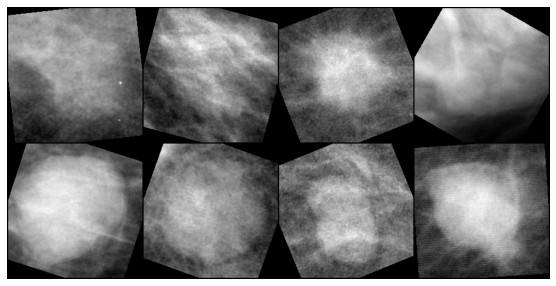

In [8]:
import torch
import torchvision
import matplotlib.pyplot as plt

# Supongamos que test_images es tu batch de imágenes con shape [8, 3, 224, 224]
# Asegúrate de que esté en el rango [0,1] o [0,255]
train_images = next(iter(train_loader2))["image"]

# Usamos make_grid para organizar las imágenes en una cuadrícula
grid_img = torchvision.utils.make_grid(train_images, nrow=4, normalize=True)

# Convertimos el tensor a NumPy y transponemos para el formato correcto (H, W, C)
plt.figure(figsize=(10, 5))
plt.imshow(grid_img.permute(1, 2, 0))  # Convertimos de (C, H, W) -> (H, W, C)
plt.axis("off")  # Ocultamos los ejes
plt.show()

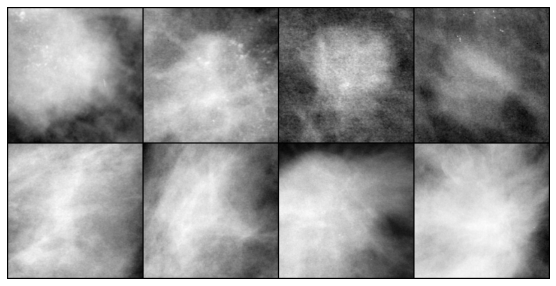

In [9]:
import torch
import torchvision
import matplotlib.pyplot as plt

# Supongamos que test_images es tu batch de imágenes con shape [8, 3, 224, 224]
# Asegúrate de que esté en el rango [0,1] o [0,255]
test_images = next(iter(test_loader2))["image"]

# Usamos make_grid para organizar las imágenes en una cuadrícula
grid_img = torchvision.utils.make_grid(test_images, nrow=4, normalize=True)

# Convertimos el tensor a NumPy y transponemos para el formato correcto (H, W, C)
plt.figure(figsize=(10, 5))
plt.imshow(grid_img.permute(1, 2, 0))  # Convertimos de (C, H, W) -> (H, W, C)
plt.axis("off")  # Ocultamos los ejes
plt.show()

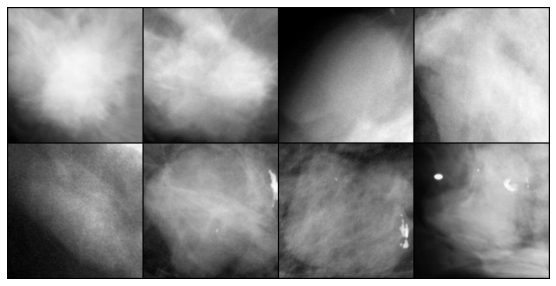

In [10]:
import torch
import torchvision
import matplotlib.pyplot as plt

# Supongamos que test_images es tu batch de imágenes con shape [8, 3, 224, 224]
# Asegúrate de que esté en el rango [0,1] o [0,255]
val_images = next(iter(val_loader2))["image"]

# Usamos make_grid para organizar las imágenes en una cuadrícula
grid_img = torchvision.utils.make_grid(val_images, nrow=4, normalize=True)

# Convertimos el tensor a NumPy y transponemos para el formato correcto (H, W, C)
plt.figure(figsize=(10, 5))
plt.imshow(grid_img.permute(1, 2, 0))  # Convertimos de (C, H, W) -> (H, W, C)
plt.axis("off")  # Ocultamos los ejes
plt.show()


Total Training Time: 60031.98 seconds

Total Training Time 16.67554931236638 hours


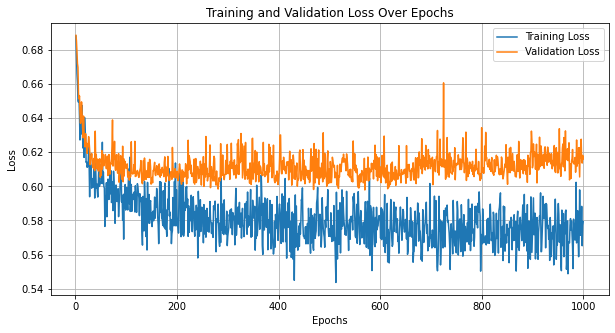

In [12]:
import torch
import matplotlib.pyplot as plt
import time

# Define the number of epochs
num_epochs = 1000

# Initialize lists to store loss values for each epoch
train_loss_history = []
val_loss_history = []

# Start timing the training process
start_time = time.time()

# Training loop
for epoch in range(num_epochs):
    epoch_start_time = time.time()  # Time for each epoch
        
    """print(f"Epoch {epoch + 1}/{num_epochs}")
    """
    
    # Switch model to training mode
    model2.train()
    running_loss = 0.0

    # Iterate over the training DataLoader
    for batch_idx, batch in enumerate(train_loader2):
        # Move images and labels to the device (GPU/CPU)
        images, labels = batch["image"].to(device), batch["label"].to(device)

        # Zero the parameter gradients
        optimizer.zero_grad()

        # Forward pass
        outputs = model2(images)

        # Calculate the loss
        loss = criterion(outputs, labels)

        # Backward pass
        loss.backward()

        # Update model weights
        optimizer.step()

        # Accumulate the loss for the batch
        running_loss += loss.item()

        # Print progress every 50 batches
        """        if (batch_idx + 1) % 50 == 0:
                    print(f"Batch {batch_idx + 1}/{len(train_loader)}, Loss: {loss.item():.4f}")
        """
    # Calculate average loss for the epoch
    epoch_loss = running_loss / len(train_loader2)
    train_loss_history.append(epoch_loss)
    """    print(f"Training Loss for Epoch {epoch + 1}: {epoch_loss:.4f}")
    """
    # Evaluate the model on the validation set
    model2.eval()  # Switch model to evaluation mode
    val_loss = 0.0

    with torch.no_grad():  # No need to calculate gradients during evaluation
        for batch in val_loader2:
            images, labels = batch["image"].to(device), batch["label"].to(device)

            # Forward pass
            outputs = model2(images)

            # Calculate validation loss
            loss = criterion(outputs, labels)
            val_loss += loss.item()

    # Calculate average validation loss
    val_loss /= len(val_loader2)
    val_loss_history.append(val_loss)
    """    print(f"Validation Loss for Epoch {epoch + 1}: {val_loss:.4f}")
    """
    # Print time taken for the epoch
    """    epoch_end_time = time.time()
        epoch_duration = epoch_end_time - epoch_start_time
        print(f"Time taken for Epoch {epoch + 1}: {epoch_duration:.2f} seconds")
    """
# End timing
end_time = time.time()
total_training_time = end_time - start_time
print(f"\nTotal Training Time: {total_training_time:.2f} seconds")
print("\nTotal Training Time" , total_training_time/60/60, "hours")

# Plot training and validation loss curves
plt.figure(figsize=(10, 5))
plt.plot(range(1, num_epochs + 1), train_loss_history, label="Training Loss")
plt.plot(range(1, num_epochs + 1), val_loss_history, label="Validation Loss")

# Labels and title
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.title("Training and Validation Loss Over Epochs")
plt.legend()
plt.grid(True)

# Show the plot
plt.show()

In [15]:
# Move model to evaluation mode
model2.to(device)

# Lists to store predictions and true labels
y_true = []
y_pred = []
y_probas = []

# Evaluate on the test set
model2.eval()
with torch.no_grad():
    for batch in test_loader2:
        images, labels = batch["image"].to(device), batch["label"].to(device)

        # Get model predictions
        outputs = model2(images)

        # Apply Softmax for probability scores
        probabilities = torch.softmax(outputs, dim=1)[:, 1].cpu().numpy()

        # Get the predicted class (argmax)
        predictions = torch.argmax(outputs, dim=1).cpu().numpy()

        # Store true labels and predictions
        y_true.extend(labels.cpu().numpy())
        y_pred.extend(predictions)
        y_probas.extend(probabilities)

# Convert lists to NumPy arrays
y_true = np.array(y_true)
y_pred = np.array(y_pred)
y_probas = np.array(y_probas)

# Compute evaluation metrics
accuracy = accuracy_score(y_true, y_pred)
balanced_acc = balanced_accuracy_score(y_true, y_pred)
roc_auc = roc_auc_score(y_true, y_probas)

# Display results
print(f"Accuracy: {accuracy:.4f}")
print(f"Balanced Accuracy: {balanced_acc:.4f}")
print(f"ROC AUC: {roc_auc:.4f}")


Accuracy: 0.6296
Balanced Accuracy: 0.6425
ROC AUC: 0.7202


Early stopping triggered after 154 epochs.

Total Training Time: 9377.15 seconds

Total Training Time 2.6047626304626466 hours


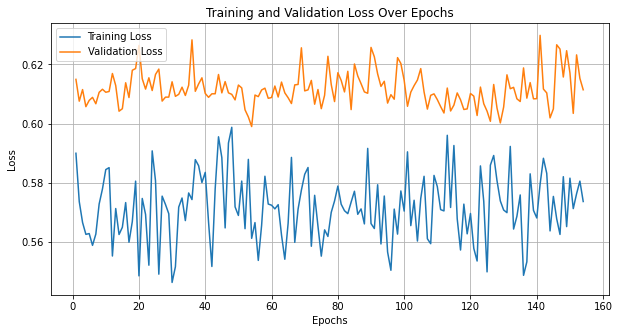

In [16]:
import torch
import matplotlib.pyplot as plt
import time

# Define maximum number of epochs and early stopping patience
max_epochs = 2000  # Maximum number of epochs
patience = 100  # Number of epochs to wait before stopping if no improvement

# Initialize lists to store loss values for each epoch
train_loss_history = []
val_loss_history = []

# Early stopping variables
best_val_loss = float('inf')  # Initialize best validation loss as infinity
patience_counter = 0  # Counter to track epochs without improvement

# Start timing the training process
start_time = time.time()

# Training loop
for epoch in range(1, max_epochs + 1):
    epoch_start_time = time.time()  # Start timer for each epoch
    
    # Switch model to training mode
    model2.train()
    running_loss = 0.0

    # Iterate over the training DataLoader
    for batch in train_loader2:
        # Move images and labels to the device (GPU/CPU)
        images, labels = batch["image"].to(device), batch["label"].to(device)

        # Zero the parameter gradients
        optimizer.zero_grad()

        # Forward pass
        outputs = model2(images)

        # Calculate the loss
        loss = criterion(outputs, labels)

        # Backward pass
        loss.backward()

        # Update model weights
        optimizer.step()

        # Accumulate the loss for the batch
        running_loss += loss.item()

    # Calculate average loss for the epoch
    epoch_loss = running_loss / len(train_loader2)
    train_loss_history.append(epoch_loss)

    # Evaluate the model on the validation set
    model2.eval()  # Switch model to evaluation mode
    val_loss = 0.0

    with torch.no_grad():  # No need to calculate gradients during evaluation
        for batch in val_loader2:
            images, labels = batch["image"].to(device), batch["label"].to(device)

            # Forward pass
            outputs = model2(images)

            # Calculate validation loss
            loss = criterion(outputs, labels)
            val_loss += loss.item()

    # Calculate average validation loss
    val_loss /= len(val_loader2)
    val_loss_history.append(val_loss)

    # Check for early stopping
    if val_loss < best_val_loss:
        best_val_loss = val_loss
        patience_counter = 0  # Reset counter when validation loss improves
    else:
        patience_counter += 1  # Increment counter if no improvement
    
    # Stop training if patience limit is reached
    if patience_counter >= patience:
        print(f"Early stopping triggered after {epoch} epochs.")
        break

    # Print epoch duration
    epoch_end_time = time.time()
    epoch_duration = epoch_end_time - epoch_start_time
    #print(f"Epoch {epoch}/{max_epochs} - Training Loss: {epoch_loss:.4f} - Validation Loss: {val_loss:.4f} - Time: {epoch_duration:.2f} sec")

# End timing
end_time = time.time()
total_training_time = end_time - start_time
print(f"\nTotal Training Time: {total_training_time:.2f} seconds")
print("\nTotal Training Time" , total_training_time/60/60, "hours")


# Plot training and validation loss curves
plt.figure(figsize=(10, 5))
plt.plot(range(1, len(train_loss_history) + 1), train_loss_history, label="Training Loss")
plt.plot(range(1, len(val_loss_history) + 1), val_loss_history, label="Validation Loss")

# Labels and title
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.title("Training and Validation Loss Over Epochs")
plt.legend()
plt.grid(True)

# Show the plot
plt.show()


In [18]:
# Move model to evaluation mode
model2.to(device)

# Lists to store predictions and true labels
y_true = []
y_pred = []
y_probas = []

# Evaluate on the test set
model2.eval()
with torch.no_grad():
    for batch in test_loader2:
        images, labels = batch["image"].to(device), batch["label"].to(device)

        # Get model predictions
        outputs = model2(images)

        # Apply Softmax for probability scores
        probabilities = torch.softmax(outputs, dim=1)[:, 1].cpu().numpy()

        # Get the predicted class (argmax)
        predictions = torch.argmax(outputs, dim=1).cpu().numpy()

        # Store true labels and predictions
        y_true.extend(labels.cpu().numpy())
        y_pred.extend(predictions)
        y_probas.extend(probabilities)

# Convert lists to NumPy arrays
y_true = np.array(y_true)
y_pred = np.array(y_pred)
y_probas = np.array(y_probas)

# Compute evaluation metrics
accuracy = accuracy_score(y_true, y_pred)
balanced_acc = balanced_accuracy_score(y_true, y_pred)
roc_auc = roc_auc_score(y_true, y_probas)

# Display results
print(f"Accuracy: {accuracy:.4f}")
print(f"Balanced Accuracy: {balanced_acc:.4f}")
print(f"ROC AUC: {roc_auc:.4f}")


Accuracy: 0.6270
Balanced Accuracy: 0.6391
ROC AUC: 0.7108
